<h1> Collaborative Filtering for Movie Recommendations </h1>

This is a follow-along of the [tutorial](https://keras.io/examples/structured_data/collaborative_filtering_movielens/) for implementing a collaborative filtering model for movie recommendations found on Keras.

<a id='toc'></a>
<h2> Table of Contents</h2>
<div class='alert alert-box alert-info'>
    <ol>
        <li><a href='#Intro'> Introduction </a></li>
        <ol>
            <li> Embeddings </li>
        </ol>
        <li><a href='#lib'> Libraries </a></li>
        <li><a href='#data'> Data </a></li>
        <ol>
            <li><a href='#viz'> Visualising data </a></li>
            <li><a href='#preprocess'> Preprocessing data </a></li>
        </ol>
        <li><a href='#build'> Building the models </a></li>
        <li><a href='#train'> Training the models </a></li>
        <li><a href='#pred'> Predictions </a></li>        
        <li><a href='#evaluate'> Evaluation </a></li>
        <li><a href='#ref'> References </a></li>
    </ol>
</div>

<a id='intro'></a>
<h2> Introduction </h2>

This notebook demonstrates [Collaborative Filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) using the [Movielens dataset](https://www.kaggle.com/c/movielens-100k) to recommend movies to users.

<b> Algorithm </b>
1. Map user ID to a 'user vector' via an [embedding matrix](https://petuum.medium.com/embeddings-a-matrix-of-meaning-4de877c9aa27)
2. Map movie ID to a 'movie vector' via an embedding matrix
3. Compute the dot product between user vector and movie vector in order to obtain the similarity score between the user and the movie
4. Train the embeddings via gradient descent using all known user-movie pairs

<h3> Embeddings </h3>

Google has an excellent tutorial on [Embeddings](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture).

In the context of movie recommendations and collaborative filtering, the idea is that user interests in movies can be roughly represented by <em>d</em> aspects. Each movie thus becomes a point in a d-dimensional space. 

The value along each dimension represents how much the movie fits that aspect. The embeddings can be learned from data. 

<b> Key idea </b>

There is no seperate training process needed. Back propogation is used and the embedding layer is just a hidden layer with one neuron for every dimension we want in our embedding. 

[Back to top](#toc)

<a id='lib'></a>
<h2> Libraries </h2>


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import requests
from tqdm import tqdm
from zipfile import ZipFile
from pathlib import Path

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import layers

[Back to top](#toc)

<a id='data'></a>
<h2> Data </h2>

In [3]:
data_url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
r = requests.get(data_url, stream=True)

data_zipped_file = 'ml-latest-small.zip'
with open(data_zipped_file, 'wb') as f:
    for chunk in r.iter_content(chunk_size=128):
        f.write(chunk)
        
with ZipFile(data_zipped_file, 'r') as z:
    z.extractall()

In [4]:
data_path = './ml-latest-small'
ratings_file = os.path.join(data_path, 'ratings.csv')
ratings_df = pd.read_csv(ratings_file)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
ratings_df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [6]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [7]:
ratings_df.duplicated().any()

False

In [8]:
movies_file = os.path.join(data_path, 'movies.csv')
movies_df = pd.read_csv(movies_file)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
movies_df.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


In [10]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [11]:
movies_df.duplicated().any()

False

In [12]:
tags_file = os.path.join(data_path, 'tags.csv')
tags_df = pd.read_csv(tags_file)
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [13]:
tags_df.tail()

,userId,movieId,tag,timestamp
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978
3682,610,168248,Heroic Bloodshed,1493844270


In [14]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


In [15]:
tags_df.duplicated().any()

False

[Back to top](#toc)

<a id='viz'></a>
<h3> Visualising data </h3>

[Back to top](#toc)

<a id='preprocess'></a>
<h3> Preprocessing data </h3>

In [16]:
user_ids = ratings_df['userId'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)} # mapping user_ids to [0, -1]
userencoded2user = {i: x for i, x in enumerate(user_ids)} # mapping [0, -1] to user_ids

In [17]:
movie_ids = ratings_df['movieId'].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)} # mapping movie_ids to [0, -1]
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)} # mapping [0, -1] to movie_ids

In [18]:
ratings_df['user'] = ratings_df['userId'].map(user2user_encoded)
ratings_df['movie'] = ratings_df['movieId'].map(movie2movie_encoded)

In [19]:
ratings_df

,userId,movieId,rating,timestamp,user,movie
0,1,1,4.0,964982703,0,0
1,1,3,4.0,964981247,0,1
2,1,6,4.0,964982224,0,2
3,1,47,5.0,964983815,0,3
4,1,50,5.0,964982931,0,4
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,609,3120
100832,610,168248,5.0,1493850091,609,2035
100833,610,168250,5.0,1494273047,609,3121
100834,610,168252,5.0,1493846352,609,1392


In [20]:
num_users = len(userencoded2user)
num_movies = len(movie_encoded2movie)

In [21]:
# df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(ratings_df["rating"])
max_rating = max(ratings_df["rating"])

In [22]:
print(
    f'Number of users: {num_users}, Number of Movies: {num_movies}, Min rating: {min_rating}, Max rating: {max_rating}'
)

Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


[Back to top](#toc)

<a id='prep'></a>
<h3> Preparing training and validation data </h3>

In [23]:
ratings_df.sample(frac=1, random_state=42) # this shuffles the dataframe
x = ratings_df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = ratings_df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * ratings_df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

[Back to top](#toc)

<a id='build'></a>
<h2> Building the models </h2>

To make sense of the following code, we can refer to the documentation [Model Class](https://keras.io/api/models/model/) and [Supercharge your Classes with Python super()](https://realpython.com/python-super/)

In [24]:
EMBEDDING_SIZE = 50 # this is the hyperparameter that chooses the number of dimensions of our embedding

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        #super(RecommenderNet, self).__init__(**kwargs)
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)

In [25]:
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

[Back to top](#toc)

<a id='train'></a>
<h2> Training the models </h2>

In [26]:
history = model.fit(
    x=x_train,
    y=y_train,
    ba 

Epoch 1/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6336 - val_loss: 0.6844
Epoch 2/5
1418/1418 [==============================] - 8s 5ms/step - loss: 0.6104 - val_loss: 0.6777
Epoch 3/5
1418/1418 [==============================] - 9s 6ms/step - loss: 0.6055 - val_loss: 0.6749
Epoch 4/5
1418/1418 [==============================] - 11s 7ms/step - loss: 0.6044 - val_loss: 0.6712
Epoch 5/5
1418/1418 [==============================] - 12s 8ms/step - loss: 0.6048 - val_loss: 0.6691


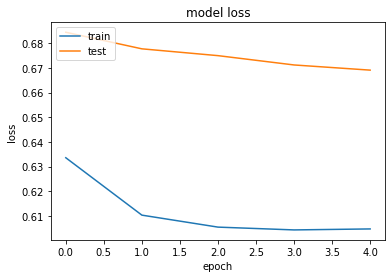

In [27]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

[Back to top](#toc)

<a id='pred'></a>
<h2> Predictions </h2>

In [104]:
# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = ratings_df[ratings_df.userId == user_id]
movies_not_watched = movies_df[
    ~movies_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movies_df_rows = movies_df[movies_df["movieId"].isin(top_movies_user)]
for row in movies_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movies_df[movies_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 474
Movies with high ratings from user
--------------------------------
Enchanted April (1992) : Drama|Romance
Strictly Ballroom (1992) : Comedy|Romance
Moonstruck (1987) : Comedy|Romance
Safety Last! (1923) : Action|Comedy|Romance
Harry Potter and the Goblet of Fire (2005) : Adventure|Fantasy|Thriller|IMAX
--------------------------------
Top 10 movie recommendations
--------------------------------
Houseguest (1994) : Comedy
Losing Isaiah (1995) : Drama
Crow, The (1994) : Action|Crime|Fantasy|Thriller
Newton Boys, The (1998) : Crime|Drama
Lethal Weapon (1987) : Action|Comedy|Crime|Drama
Candleshoe (1977) : Adventure|Children|Comedy
Hairspray (1988) : Comedy|Drama
Live and Let Die (1973) : Action|Adventure|Thriller
Proposal, The (2009) : Comedy|Romance
Lincoln Lawyer, The (2011) : Crime|Drama|Thriller


[Back to top](#toc)

<a id='evaluate'></a>
<h2> Evaluation </h2>

[Back to top](#toc)

<a id='ref'></a>
<h2> References </h2>
<ol>
    <li><a href='https://dl.acm.org/doi/abs/10.1145/371920.372071'> Item-based collaborative filtering recommendation algorithms </a></li>
    <li><a href='https://dl.acm.org/doi/abs/10.1145/3038912.3052569'> Neural Collaborative Filtering </a></li>
    <li><a href='https://petuum.medium.com/embeddings-a-matrix-of-meaning-4de877c9aa27'> Embeddings: A Matrix of Meaning </a></li>
    <li><a href='https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture'> Embeddings from Google's <em>Machine Learning Crash Course</em> </a></li>
    <li><a href='https://keras.io/api/models/model/'> Keras The Model Class </a></li>
    <li><a href='https://realpython.com/python-super/'> Supercharge your Classes with Python super() </a></li>
    <li><a href='https://youtu.be/v_mONWiFv0k'> How to Design and Build a Recommendation System Pipeline in Python (Jill Cates) </a></li>
</ol>


[Back to top](#toc)